# 第4章: 形態素解析

In [1]:
import MeCab

with open('neko.txt') as rf ,open('neko.txt.mecab', 'w') as wf:
    mecab = MeCab.Tagger()
    wf.write(mecab.parse(rf.read()))

In [2]:
%%bash
head neko.txt.mecab

一	名詞,数,*,*,*,*,一,イチ,イチ
　	記号,空白,*,*,*,*,　,　,　
吾輩	名詞,代名詞,一般,*,*,*,吾輩,ワガハイ,ワガハイ
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
猫	名詞,一般,*,*,*,*,猫,ネコ,ネコ
で	助動詞,*,*,*,特殊・ダ,連用形,だ,デ,デ
ある	助動詞,*,*,*,五段・ラ行アル,基本形,ある,アル,アル
。	記号,句点,*,*,*,*,。,。,。
名前	名詞,一般,*,*,*,*,名前,ナマエ,ナマエ
は	助詞,係助詞,*,*,*,*,は,ハ,ワ


### 30. 形態素解析結果の読み込み
> 形態素解析結果（neko.txt.mecab）を読み込むプログラムを実装せよ．ただし，各形態素は表層形（surface），基本形（base），品詞（pos），品詞細分類1（pos1）をキーとするマッピング型に格納し，1文を形態素（マッピング型）のリストとして表現せよ．第4章の残りの問題では，ここで作ったプログラムを活用せよ．

In [3]:
def mapping(word):
    # word: 表層形\t品詞,品詞細分類1,品詞細分類2,品詞細分類3,活用型,活用形,原形,読み,発音
    surface, rest = word.split('\t')
    rest = rest.split(',')
    return dict(zip(['surface', 'base', 'pos', 'pos1'],[surface, rest[6], rest[0], rest[1]]))
        
def bundle():
    sentence = []
    with open('neko.txt.mecab') as f:
        for word in f:
            if word == 'EOS\n':
                continue
            sentence.append(mapping(word))
            if word[0] == '。':
                yield sentence
                sentence = []

neko = [sentence for sentence in bundle()]

print(*neko[:3], sep="\n")

[{'surface': '一', 'base': '一', 'pos': '名詞', 'pos1': '数'}, {'surface': '\u3000', 'base': '\u3000', 'pos': '記号', 'pos1': '空白'}, {'surface': '吾輩', 'base': '吾輩', 'pos': '名詞', 'pos1': '代名詞'}, {'surface': 'は', 'base': 'は', 'pos': '助詞', 'pos1': '係助詞'}, {'surface': '猫', 'base': '猫', 'pos': '名詞', 'pos1': '一般'}, {'surface': 'で', 'base': 'だ', 'pos': '助動詞', 'pos1': '*'}, {'surface': 'ある', 'base': 'ある', 'pos': '助動詞', 'pos1': '*'}, {'surface': '。', 'base': '。', 'pos': '記号', 'pos1': '句点'}]
[{'surface': '名前', 'base': '名前', 'pos': '名詞', 'pos1': '一般'}, {'surface': 'は', 'base': 'は', 'pos': '助詞', 'pos1': '係助詞'}, {'surface': 'まだ', 'base': 'まだ', 'pos': '副詞', 'pos1': '助詞類接続'}, {'surface': '無い', 'base': '無い', 'pos': '形容詞', 'pos1': '自立'}, {'surface': '。', 'base': '。', 'pos': '記号', 'pos1': '句点'}]
[{'surface': '\u3000', 'base': '\u3000', 'pos': '記号', 'pos1': '空白'}, {'surface': 'どこ', 'base': 'どこ', 'pos': '名詞', 'pos1': '代名詞'}, {'surface': 'で', 'base': 'で', 'pos': '助詞', 'pos1': '格助詞'}, {'surface': '生れ', 'base': '生れ

### 31. 動詞
> 動詞の表層形をすべて抽出せよ．

In [4]:
l = [d['surface'] for phrase in bundle() for d in phrase if d['pos'] == '動詞']
print(l[:20])
s = set(l)

['生れ', 'つか', 'し', '泣い', 'し', 'いる', '始め', '見', '聞く', '捕え', '煮', '食う', '思わ', '載せ', 'られ', '持ち上げ', 'られ', 'し', 'あっ', '落ちつい']


### 32. 動詞の原形
> 動詞の原形をすべて抽出せよ．

In [5]:
l = [d['base'] for phrase in bundle() for d in phrase if d['pos'] == '動詞']
print(l[:20])
s = set(l)

['生れる', 'つく', 'する', '泣く', 'する', 'いる', '始める', '見る', '聞く', '捕える', '煮る', '食う', '思う', '載せる', 'られる', '持ち上げる', 'られる', 'する', 'ある', '落ちつく']


### 33. 「AのB」
> 2つの名詞が「の」で連結されている名詞句を抽出せよ．

In [6]:
l = []
for sentence in bundle():
    indexes = [i for i, x in enumerate(sentence) if x['base'] == 'の']
    for k in indexes:
        if sentence[k-1]['pos'] == sentence[k+1]['pos'] == '名詞':
            l.append(sentence[k-1]['surface'] + 'の' + sentence[k+1]['surface'])
print(l[:10])
s = set(l)

['彼の掌', '掌の上', '書生の顔', 'はずの顔', '顔の真中', '穴の中', '書生の掌', '掌の裏', '何の事', '肝心の母親']


### 34. 名詞の連接
> 名詞の連接（連続して出現する名詞）を最長一致で抽出せよ．

In [7]:
from itertools import groupby

l = []
keyfunc = lambda x:x['pos']
for sentence in bundle():
    # example: 
    # key = '名詞'
    # group = [{'surface': '一', 'base': '一', 'pos': '名詞', 'pos1': '数'}, 
    #          {'surface': '毛', 'base': '毛', 'pos': '名詞', 'pos1': '接尾'}]
    for key, group in groupby(sentence, keyfunc):
        g = list(group)
        if key == '名詞' and len(g) > 1:
            l.append(''.join([x['surface'] for x in g]))
print(l[:20])
s = set(l)

['人間中', '一番獰悪', '時妙', '一毛', 'その後猫', '一度', 'ぷうぷうと煙', '邸内', '三毛', '書生以外', '四五遍', 'この間おさん', '三馬', '御台所', 'まま奥', '住家', '終日書斎', '勉強家', '勉強家', '勤勉家']


### 35. 単語の出現頻度
> 文章中に出現する単語とその出現頻度を求め，出現頻度の高い順に並べよ．

In [8]:
from collections import Counter

l = [d['surface'] for sentence in bundle() for d in sentence]
c = Counter(l)
top10 = c.most_common(10)
print(top10)

[('の', 9194), ('。', 7486), ('て', 6873), ('、', 6772), ('は', 6422), ('に', 6268), ('を', 6071), ('と', 5515), ('が', 5339), ('た', 3989)]


### 36. 頻度上位10語
> 出現頻度が高い10語とその出現頻度をグラフ（例えば棒グラフなど）で表示せよ．

In [9]:
%matplotlib inline

<BarContainer object of 10 artists>

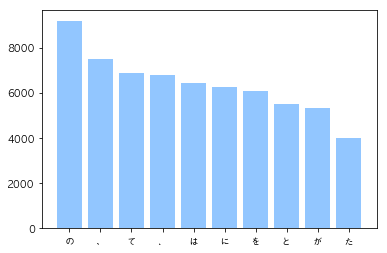

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

mpl.rcParams['font.family'] = 'AppleGothic'
sns.set_palette("pastel")
left = range(10)
height = [n for x, n in top10]
label = [x for x, n in top10]
plt.bar(left, height, tick_label=label)

### 37. 「猫」と共起頻度の高い上位10語
> 「猫」とよく共起する（共起頻度が高い）10語とその出現頻度をグラフ（例えば棒グラフなど）で表示せよ．

<BarContainer object of 10 artists>

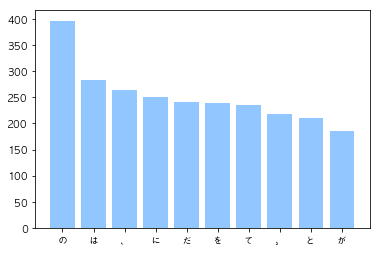

In [11]:
neko_friends = Counter()
for sentence in bundle():
    sentence = [word['base'] for word in sentence]
    if '猫' in sentence:
        neko_friends.update(sentence)
neko_friends['猫'] = 0
top10 = neko_friends.most_common(10)

left = range(10)
height = [n for x, n in top10]
label = [x for x, n in top10]
plt.bar(left, height, tick_label=label)

### 38. ヒストグラム
> 単語の出現頻度のヒストグラム（横軸に出現頻度，縦軸に出現頻度をとる単語の種類数を棒グラフで表したもの）を描け．

(array([6201., 2267., 1116.,  686.,  537.,  348.,  276.,  241.,  172.,
         127.,  117.,  111.,  102.,   91.,   79.]),
 array([ 1.        ,  1.93333333,  2.86666667,  3.8       ,  4.73333333,
         5.66666667,  6.6       ,  7.53333333,  8.46666667,  9.4       ,
        10.33333333, 11.26666667, 12.2       , 13.13333333, 14.06666667,
        15.        ]),
 <a list of 15 Patch objects>)

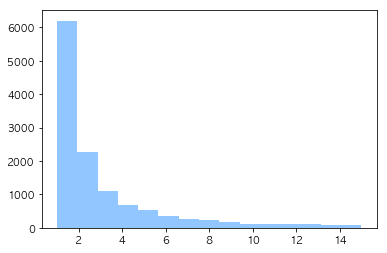

In [12]:
plt.hist(c.values(),bins=15,range=(1,15))

### 39. Zipfの法則

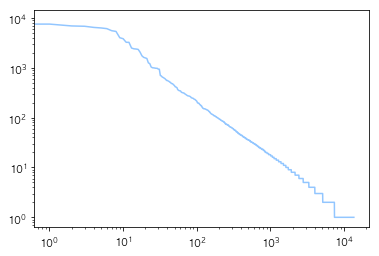

In [13]:
# 単語の出現頻度順位を横軸，その出現頻度を縦軸として，両対数グラフをプロットせよ．
r = c.most_common()
x = range(len(r))
y = [y for x,y in r]
plt.xscale('log')
plt.yscale('log')
plt.plot(x, y)